copy from: https://www.kaggle.com/code/andrealunch/enefit-eda-first-exploration

# <b><span style='color:skyblue'>0 |</span> 数据导入</b>

In [1]:
import numpy as np 
import pandas as pd
df_train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
df_client = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv')
df_gas_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv')
df_electricity_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv')
df_station_to_county = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv')
df_historical_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv')
df_forecast_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv')
dict_df = {'df_train':df_train, 'df_client':df_client, 'df_gas_prices':df_gas_prices, 
           'df_electricity_prices': df_electricity_prices, 'df_station_to_county':df_station_to_county, 
           'df_historical_weather':df_historical_weather, 'df_forecast_weather':df_forecast_weather}

# <b><span style='color:skyblue'>1 |</span> 关于可用数据的一些信息</b>

In [2]:
for df in dict_df.keys():
    print(df)
    print("shape:", dict_df[df].shape)
    print("columns: ", [col for col in dict_df[df].columns])
    print("")

df_train
shape: (2018352, 9)
columns:  ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime', 'data_block_id', 'row_id', 'prediction_unit_id']

df_client
shape: (41919, 7)
columns:  ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date', 'data_block_id']

df_gas_prices
shape: (637, 5)
columns:  ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh', 'origin_date', 'data_block_id']

df_electricity_prices
shape: (15286, 4)
columns:  ['forecast_date', 'euros_per_mwh', 'origin_date', 'data_block_id']

df_station_to_county
shape: (112, 4)
columns:  ['county_name', 'longitude', 'latitude', 'county']

df_historical_weather
shape: (1710802, 18)
columns:  ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'latitude', 'lo

In [3]:
import json
f = open('/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json')
json.load(f)

{'0': 'HARJUMAA',
 '1': 'HIIUMAA',
 '2': 'IDA-VIRUMAA',
 '3': 'JÄRVAMAA',
 '4': 'JÕGEVAMAA',
 '5': 'LÄÄNE-VIRUMAA',
 '6': 'LÄÄNEMAA',
 '7': 'PÄRNUMAA',
 '8': 'PÕLVAMAA',
 '9': 'RAPLAMAA',
 '10': 'SAAREMAA',
 '11': 'TARTUMAA',
 '12': 'UNKNOWN',
 '13': 'VALGAMAA',
 '14': 'VILJANDIMAA',
 '15': 'VÕRUMAA'}

# <b><span style='color:skyblue'>2 |</span> EDA</b>
## 探索每个数据集的内容
### 训练集

#### 由竞赛文档得知
* **county** - country对应的ID代码
* **is_business** - 布尔值，表示该消费者是否为企业
* **product_type** - 合同类型对应的ID码:{0:组合、1:固定、2:通用、3:现货}。
* **target** - 每小时相关部门的消耗量或生产量。这些段由县、is_business和product_type定义
* **is_consumption** - 布尔值，表示该行的目标是消费还是生产
* **datetime** - 爱沙尼亚的EET (UTC+2) / EEST (UTC+3)时间
* **data_block_id** - 共享相同data_block_id的所有行将在同一预测时间可用。这是每天上午11点实际预报时可用信息的函数。例如，如果10月31日的天气预报data_block_id是100，那么10月31日的历史天气数据data_block_id将是101，因为历史天气数据实际上只在第二天可用
* **row_id** - 行的唯一标识符
* **prediction_unit_id** - country、is_business和product_type组合的唯一标识符。新的预测单元可以在测试集中出现或消失

In [4]:
df_train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


从文档中，我看到预测单元是由“county”、“is_business”和“product_type”的组合组成的。让我们看看有多少种组合:

In [5]:
print(df_train.county.value_counts())
print(df_train.is_business.value_counts())
print(df_train.product_type.value_counts())

county
0     212928
11    198000
7     173088
5     151632
15    148752
4     147264
10    134640
14    125808
3     122496
9     122496
13    121056
2     115200
1      91872
8      91872
6      30624
12     30624
Name: count, dtype: int64
is_business
1    1083504
0     934848
Name: count, dtype: int64
product_type
3    918720
1    781632
0    170544
2    147456
Name: count, dtype: int64


我们有16个国家(如上面打开的JSON文件所示)和4种产品类型。
接下来进行一些可视化操作

[Text(0.5, 1.0, 'distribution of target')]

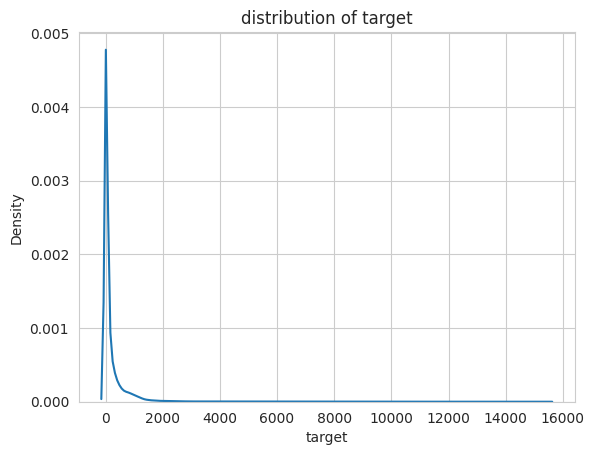

In [6]:
import seaborn as sns
sns.set_style("whitegrid")
sns.kdeplot(data = df_train, x = 'target').set(title = 'distribution of target')

[Text(0.5, 1.0, 'Target distribution splitting by consumption and production\n Consuption is much higher than production')]

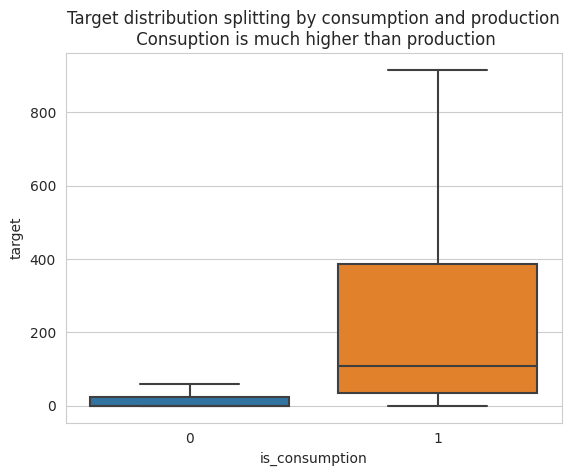

In [7]:
title = 'Target distribution splitting by consumption and production\n Consuption is much higher than production'
sns.boxplot(data = df_train, x = 'is_consumption', y = 'target', showfliers = False).set(title = title)

[Text(0.5, 1.0, 'Target distribution splitting by county\n Quite different distributions of target show up')]

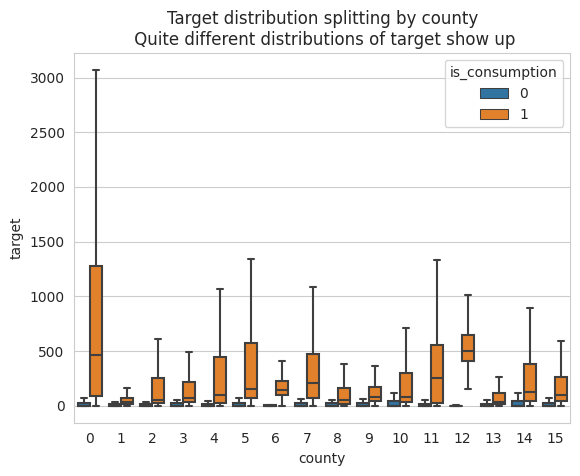

In [8]:
title = 'Target distribution splitting by county\n Quite different distributions of target show up'
sns.boxplot(data = df_train, x = 'county', y = 'target', hue = 'is_consumption', showfliers = False).set(title = title)

[Text(0.5, 1.0, 'Target distribution splitting by product_type\n Product types 0 (Combined) and 3 (Spot) show higher values of target')]

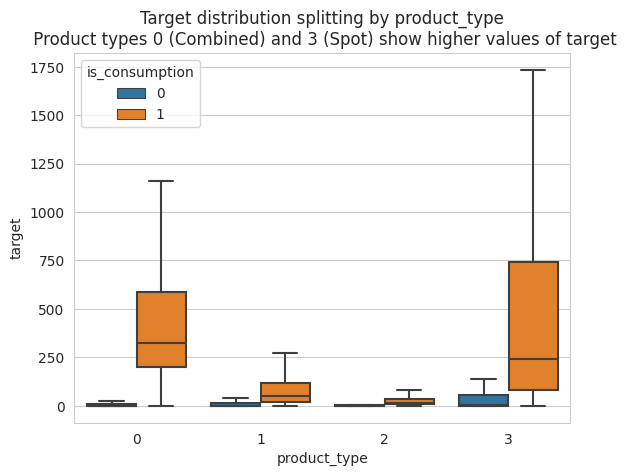

In [9]:
title = 'Target distribution splitting by product_type\n Product types 0 (Combined) and 3 (Spot) show higher values of target'
sns.boxplot(data = df_train, x = 'product_type', y = 'target', hue = 'is_consumption', showfliers = False).set(title = title)

### df_client
* **product_type**
* **county** - 国家的ID代码。看到county_id_to_name_map。json用于ID代码到国家名称的映射
* **eic_count** - 消费点的总数(EICs - europeanidentifier Code)
* **installed_capacity** - 已安装的光伏太阳能电池板容量，单位为千瓦
* **is_business** - 布尔值，表示该消费者是否为企业
* **date**
* **data_block_id**

In [10]:
df_client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


[Text(0.5, 1.0, 'Installed capcity by county')]

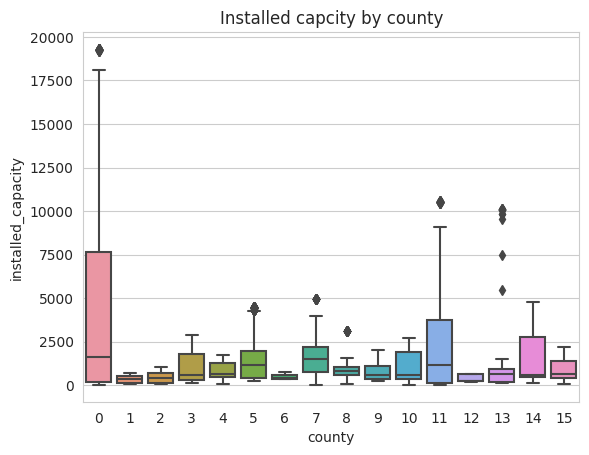

In [11]:
title = 'Installed capcity by county'
sns.boxplot(data = df_client, x = 'county', y = 'installed_capacity').set(title = title)

[Text(0.5, 1.0, 'Eic count by county\n Notice the correlation between the Eic count and the consumption plotted before:\n counties 0, 7, 11 have high consumption but also high Eic count!')]

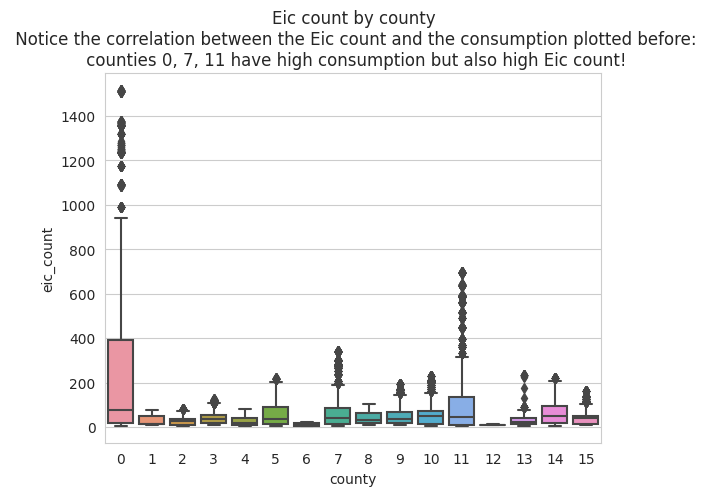

In [12]:
title = 'Eic count by county\n Notice the correlation between the Eic count and the consumption plotted before:\n \
counties 0, 7, 11 have high consumption but also high Eic count!'
sns.boxplot(data = df_client, x = 'county', y = 'eic_count').set(title = title)

### df_gas
* **origin_date** - 前一天价格可用的日期
* **forecast_date** - 预测价格应该相关的日期
* **[lowest/highest]_price_per_mwh** - 前一天市场上天然气的最低/最高价格，单位为每兆瓦时等值欧元
* **data_block_id**

In [13]:
df_gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


[Text(0.5, 1.0, 'Prices per mwh'),
 Text(0, 0.5, 'lowest_highest_price_per_mwh')]

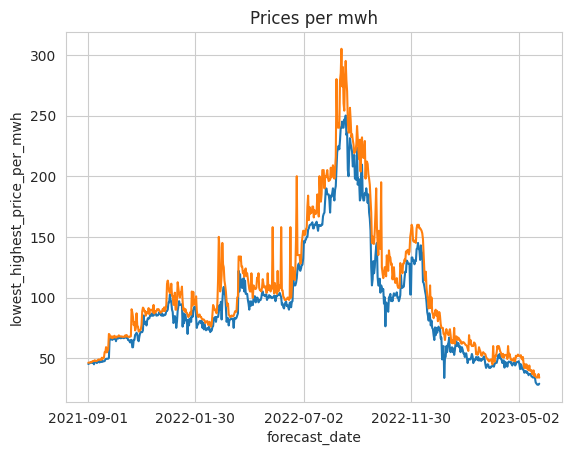

In [14]:
import matplotlib.dates as mdates
title = 'Prices per mwh'
ax = sns.lineplot(data = df_gas_prices, x = 'forecast_date', y = 'lowest_price_per_mwh')
sns.lineplot(data = df_gas_prices, x = 'forecast_date', y = 'highest_price_per_mwh')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.set(title = title, ylabel = 'lowest_highest_price_per_mwh')

### df_electricity

In [15]:
df_electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


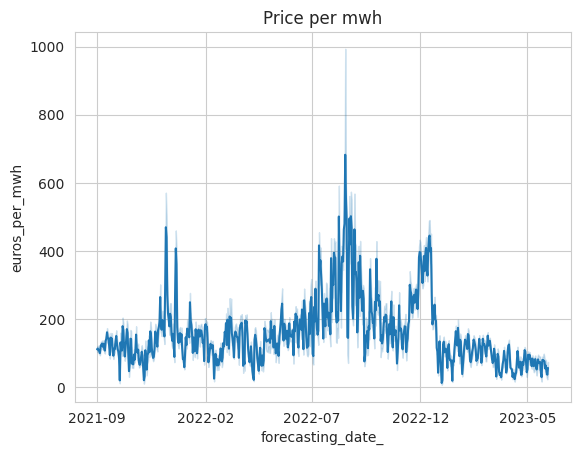

In [16]:
df_electricity_prices['forecasting_date_'] = pd.to_datetime(df_electricity_prices.forecast_date).dt.date
title = 'Price per mwh'
ax = sns.lineplot(data = df_electricity_prices, x = 'forecasting_date_', y = 'euros_per_mwh')
ax.set(title = title)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))

### df_station_to_county


In [17]:
df_station_to_county.head()

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN


In [18]:
print("there are", df_station_to_county.county_name.isna().sum(), "nans")
df_station_to_county.county_name.value_counts()

there are 63 nans


county_name
Harjumaa         6
Pärnumaa         5
Võrumaa          5
Saaremaa         4
Tartumaa         4
Lääne-Virumaa    4
Ida-Virumaa      4
Raplamaa         3
Viljandimaa      3
Järvamaa         3
Jõgevamaa        3
Läänemaa         2
Hiiumaa          1
Valgamaa         1
Põlvamaa         1
Name: count, dtype: int64

### df_forecast_weather
* **[latitude/longitude]** - 天气预报的坐标
* **origin_datetime** - 生成预测的时间戳
* **hours_ahead** - 预报生成和预报天气之间的小时数。每次天气预报共覆盖48小时温度-距离地面2米的空气温度，单位为摄氏度
* **temperature** - 温度在地面以上2米，以摄氏度为单位
* **dewpoint** - The dew point temperature at 2 meters above ground in degrees Celsius.
* **cloudcover_[low/mid/high/total]** - 在以下高度带(0-2公里、2-6公里、6+和总)内被云覆盖的天空百分比
* **10_metre_[u/v]_wind_component** - 在地表以上10米处测得的风速[向东/向北]分量，单位为米/秒
* **data_block_id**
* **forecast_datetime** - 预测天气的时间戳。由origin_datetime加上hours_ahead生成
* **direct_solar_radiation** - 在前一小时内，在垂直于太阳方向的平面上到达表面的直接太阳辐射，单位为每平方米瓦时
* **surface_solar_radiation_downwards** - 到达地球表面水平面的直接和漫射太阳辐射，单位为每平方米瓦时
* **snowfall** - 前一小时的降雪量，单位为米水当量
* **total_precipitation** - 在前一小时内落在地球表面的累积的液体，包括雨和雪，单位为米

In [19]:
df_forecast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-08-31 23:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-08-31 23:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-08-31 23:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-08-31 23:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-08-31 23:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0


**检查这里的每个纬度/经度组合是否与df_station_to_county数据帧相匹配**

In [20]:
df_forecast_weather.merge(df_station_to_county, how = 'left', on = ['latitude', 'longitude'], validate = 'm:1').head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county_name,county
0,57.6,21.7,2021-08-31 23:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0,NaN,NaN
1,57.6,22.2,2021-08-31 23:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0,NaN,NaN
2,57.6,22.7,2021-08-31 23:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0,NaN,NaN
3,57.6,23.2,2021-08-31 23:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0,NaN,NaN
4,57.6,23.7,2021-08-31 23:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0,NaN,NaN


**实际上，数据框架之间存在“多对一”的关系**
#### 可视化

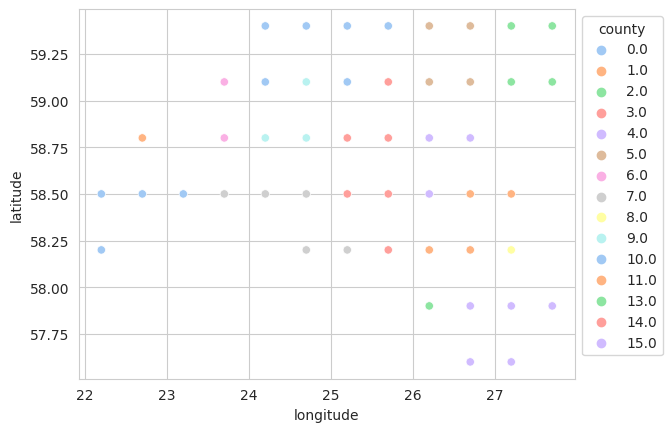

In [21]:
ax = sns.scatterplot(data = df_station_to_county, x = 'longitude', y = 'latitude', hue = 'county', palette = 'pastel')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [22]:
df_forecast_weather.columns

Index(['latitude', 'longitude', 'origin_datetime', 'hours_ahead',
       'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'data_block_id', 'forecast_datetime',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation'],
      dtype='object')

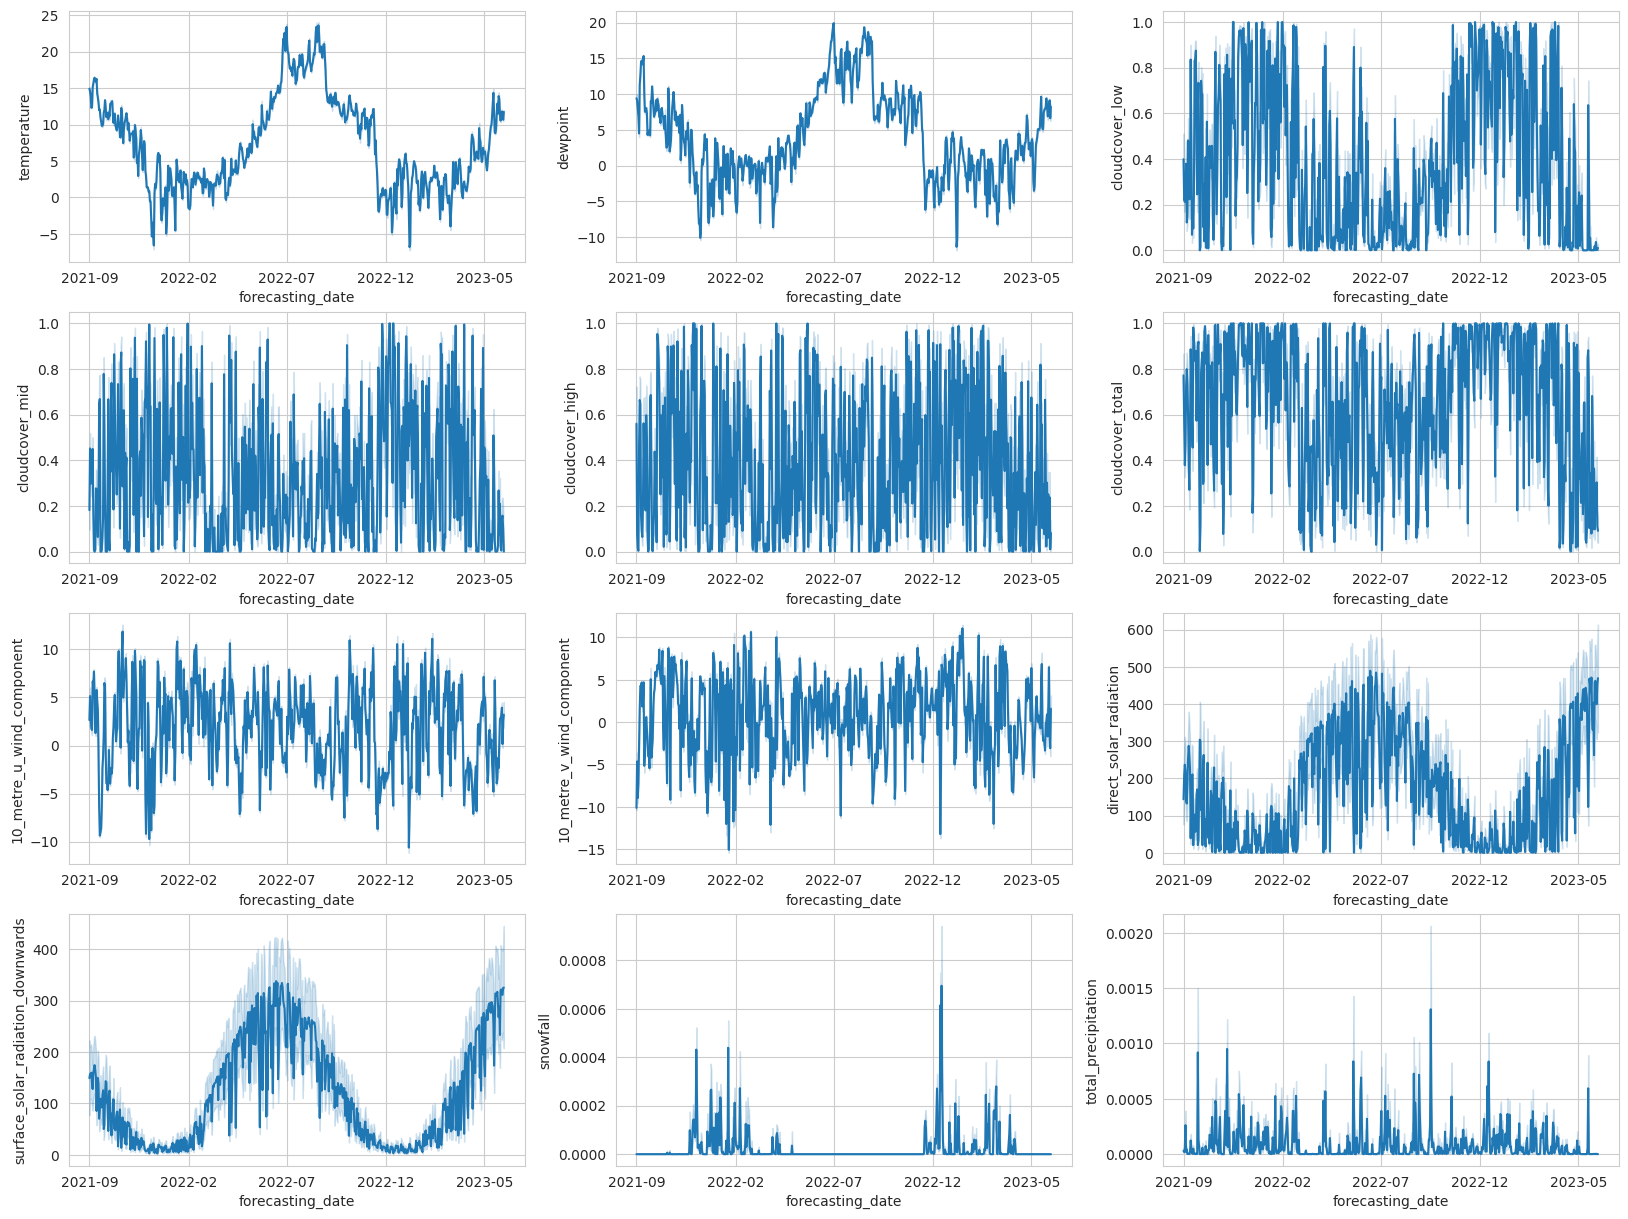

In [23]:
import matplotlib.pyplot as plt
df_forecast_weather['forecasting_date'] = pd.to_datetime(df_forecast_weather.forecast_datetime).dt.date
fig, axes = plt.subplots(4,3, figsize = (20,15))
title = 'Some indicators for a randomly chosen station'
for i, indicator in enumerate(['temperature', 'dewpoint', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 
                               'cloudcover_total', '10_metre_u_wind_component','10_metre_v_wind_component',
                               'direct_solar_radiation', 'surface_solar_radiation_downwards','snowfall', 
                               'total_precipitation']):
    ax = axes[i//3, i%3]
    sns.lineplot(data = df_forecast_weather.query("latitude == 57.6 & longitude == 21.7"), \
                                                  x = 'forecasting_date', y = indicator, ax = ax)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))

### df_historical_weather
* **datetime**
* **temperature**
* **dewpoint**
* **rain** - 不同于天气预报惯例。前一小时大尺度天气系统的降雨量，以毫米为单位
* **snowfall** - 不同于预报惯例。前一小时的降雪量，以厘米为单位
* **surface_pressure** - 地表气压，单位为百帕斯卡
* **cloudcover_[low/mid/high/total]** - 与预报惯例不同。0-3公里，3-8公里，8+和总云量
* **windspeed_10m** - 不同于预报惯例。距离地面10米处的风速，单位是米/秒
* **winddirection_10m** - 不同于预报惯例。风向在地面以上10米处，以度计
* **shortwave_radiation** - 不同于预报惯例。以每平方米瓦时为单位的全球水平辐照量
* **direct_solar_radiation**
* **diffuse_radiation** -不同于预报惯例。以瓦时每平方米计的太阳漫射辐射
* **[latitude/longitude]** - 气象站坐标
* **data_block_id**

#### **note**
这里的许多栏与预报不同:例如，云的分层是不同的

In [24]:
df_historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


**比较天气预报和实际天气** 

首先，我们需要将两个数据框架中的预测日期与实际日期相匹配

In [25]:
df_historical_weather['datetime'] = pd.to_datetime(df_historical_weather['datetime'])
df_forecast_weather['forecast_datetime'] = pd.to_datetime(df_forecast_weather['forecast_datetime']).dt.tz_localize(None)
df_weather_merged = df_historical_weather.merge(df_forecast_weather, left_on = ['datetime', 'latitude', 'longitude'], 
                            right_on = ['forecast_datetime', 'latitude', 'longitude'], how = 'inner', suffixes = ['_real', '_pred'])

In [26]:
#checking the shapes: seems ok!
print(df_historical_weather.shape)
print(df_forecast_weather.shape)
print(df_weather_merged.shape)

(1710802, 18)
(3424512, 19)
(3418916, 35)


现在我们可以计算实际数据和预测数据之间的差异

In [27]:
df_weather_merged.columns

Index(['datetime', 'temperature_real', 'dewpoint_real', 'rain',
       'snowfall_real', 'surface_pressure', 'cloudcover_total_real',
       'cloudcover_low_real', 'cloudcover_mid_real', 'cloudcover_high_real',
       'windspeed_10m', 'winddirection_10m', 'shortwave_radiation',
       'direct_solar_radiation_real', 'diffuse_radiation', 'latitude',
       'longitude', 'data_block_id_real', 'origin_datetime', 'hours_ahead',
       'temperature_pred', 'dewpoint_pred', 'cloudcover_high_pred',
       'cloudcover_low_pred', 'cloudcover_mid_pred', 'cloudcover_total_pred',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'data_block_id_pred', 'forecast_datetime',
       'direct_solar_radiation_pred', 'surface_solar_radiation_downwards',
       'snowfall_pred', 'total_precipitation', 'forecasting_date'],
      dtype='object')

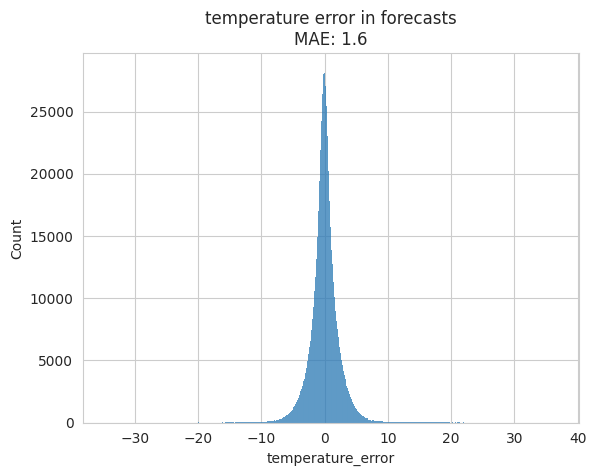

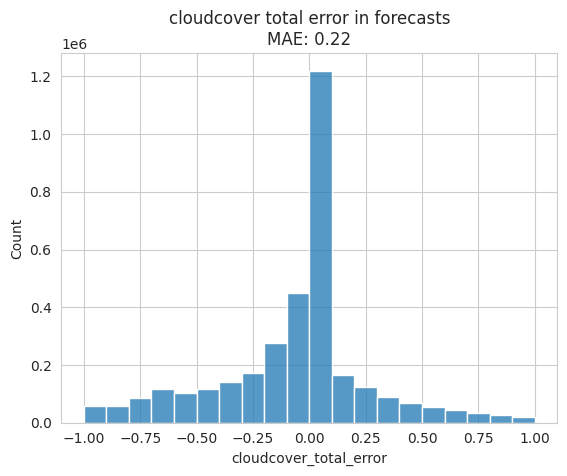

In [28]:
df_weather_merged['temperature_error'] = df_weather_merged['temperature_real'] - df_weather_merged['temperature_pred']
df_weather_merged['cloudcover_total_error'] = df_weather_merged['cloudcover_total_real'] / 100 - df_weather_merged['cloudcover_total_pred'] 
title1 = f"temperature error in forecasts\nMAE: {round(df_weather_merged['temperature_error'].abs().mean(),2)}"
sns.histplot(data = df_weather_merged, x = 'temperature_error').set(title = title1)
plt.show()
title1 = f"cloudcover total error in forecasts\nMAE: {round(df_weather_merged['cloudcover_total_error'].abs().mean(),2)}"
sns.histplot(data = df_weather_merged, x = 'cloudcover_total_error', bins = 20).set(title = title1)
plt.show()

**温度预报的平均误差似乎很低**